In [3]:
import torch
import numpy as np
import cv2
import os
import random as rand
import torchvision
import pandas as pd
from tqdm import tqdm
from torch import nn, Tensor
import matplotlib.pyplot as plt
from typing import Optional
from torch.nn import functional as F
from torchvision.transforms import v2 as T
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from math import ceil

In [4]:
class CIFAR(Dataset):
    def __init__(self, path="/scratch/s25090/archive/cifar-10/train", dataset:Optional[list]=None):
        super().__init__()
        self.path = path
        self.files = os.listdir(self.path) if dataset is None else dataset
        self.T = T.Compose([
           T.ToImage(), 
           T.ToDtype(torch.float32, scale=True),
           T.Resize((32, 32)),
           T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self,):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        img_path = os.path.join(self.path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.T(img)
        return img

In [5]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, is_final):
        super().__init__()
        layers = [
            nn.Conv2d(in_channel, (out_channel+in_channel)//2, 3, 1, 1),
            nn.BatchNorm2d((out_channel+in_channel)//2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d((in_channel+out_channel)//2, out_channel, 3, 1, 1)
        ]
        
        if not is_final:
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        layers.append(nn.UpsamplingNearest2d(scale_factor=2))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

class DisBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channel, (out_channel+in_channel)//2, 3, 1, 1),
            nn.BatchNorm2d((out_channel+in_channel)//2),
            nn.LeakyReLU(0.2),
            nn.Conv2d((out_channel+in_channel)//2, out_channel, 3, 1, 1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        return self.layer(x)

class ResGenBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        )
        
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.initial_linear = nn.Linear(z_dim, 1024 * 4 * 4)
        
        self.net = nn.Sequential(
            GenBlock(1024, 512, is_final=False), 
            GenBlock(512, 256, is_final=False),  
            GenBlock(256, 128,  is_final=False), 
            GenBlock(128,  64,  is_final=False),
            GenBlock(64,  64,  is_final=True),
        )
        
        self.final_layer = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        if len(z.shape) > 2:
            z = z.view(z.size(0), -1)
            
        x = self.initial_linear(z)
        x = x.view(-1, 1024, 4, 4)
        x = self.net(x)
        return self.final_layer(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            DisBlock(3, 32),   
            DisBlock(32, 64),
            DisBlock(64, 128),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1) 
        )

    def forward(self, x):
        x = self.net(x)
        return self.classifier(x)

class ResNetGenerator(nn.Module):
    def __init__(self, z_dim=100, base_channels=256):
        super().__init__()
        self.linear = nn.Linear(z_dim, 4 * 4 * base_channels)
        self.base_channels = base_channels

        self.blocks = nn.Sequential(
            ResGenBlock(base_channels, base_channels),    
            ResGenBlock(base_channels, base_channels // 2), 
            ResGenBlock(base_channels // 2, base_channels // 4),
        )
        
        self.final_layer = nn.Sequential(
            nn.BatchNorm2d(base_channels // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels // 4, 3, 3, 1, 1), 
            nn.Tanh() 
        )

    def forward(self, z):
        if z.ndim > 2: z = z.view(z.size(0), -1)
            
        x = self.linear(z)
        x = x.view(-1, self.base_channels, 4, 4)
        x = self.blocks(x)
        return self.final_layer(x)

class WGANModel(nn.Module):
    def __init__(self, z_dim=100, is_res=True):
        super().__init__()
        self.generator = Generator(z_dim) if not is_res else ResNetGenerator()
        self.discriminator = Discriminator()
        self.z_dim = z_dim

    def forward(self, z):
        return self.generator(z)

    def compute_discriminator_loss(self, real_imgs, z):
        with torch.no_grad():
            fake_imgs = self.generator(z).detach()

        real_logits = self.discriminator(real_imgs)
        fake_logits = self.discriminator(fake_imgs)

        d_loss = -(torch.mean(real_logits) - torch.mean(fake_logits))
        
        return d_loss

    def compute_generator_loss(self, z):
        fake_imgs = self.generator(z)
        
        fake_logits = self.discriminator(fake_imgs)
        
        g_loss = -torch.mean(fake_logits)
        
        return g_loss, fake_imgs

In [7]:
# LEARNING_RATE = 5e-5        
# WEIGHT_CLIP = 0.01
# N_CRITIC = 5  
# DEVICE = 'cuda:3' if torch.cuda.is_available() else 'cpu'
# epochs = 300

# gan_model = WGANModel()
# gan_model = gan_model.to(DEVICE)

# opt_gen = torch.optim.RMSprop(gan_model.generator.parameters(), lr=LEARNING_RATE)
# opt_dis = torch.optim.RMSprop(gan_model.discriminator.parameters(), lr=LEARNING_RATE)

# train_dataset = CIFAR()
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# gen_loss_list = []
# dis_loss_list = []

# for epoch in range(epochs):
#     gan_model.train()
#     tqdm_data = tqdm(train_loader, desc=f"Epoch-{epoch+1}/{epochs}")
    
#     batch_gen_loss = 0
#     batch_dis_loss = 0
    
#     for batch_idx, (real_img) in enumerate(tqdm_data):
#         real_img = real_img.to(DEVICE)
#         bs = real_img.size(0)

#         for param in gan_model.discriminator.parameters():
#             param.requires_grad = True

#         z_dis = torch.randn(bs, 100).to(DEVICE)
#         opt_dis.zero_grad()
        
#         dis_loss = gan_model.compute_discriminator_loss(real_img, z_dis)
#         dis_loss.backward()
#         opt_dis.step()

#         for p in gan_model.discriminator.parameters():
#             p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
        
#         batch_dis_loss += dis_loss.item()

#         if batch_idx % N_CRITIC == 0:
#             for param in gan_model.discriminator.parameters():
#                 param.requires_grad = False # Freeze D to save computation
            
#             z = torch.randn(bs, 100).to(DEVICE)
#             opt_gen.zero_grad()
            
#             gen_loss, fake_img = gan_model.compute_generator_loss(z)
#             gen_loss.backward()
#             opt_gen.step()
            
#             batch_gen_loss += gen_loss.item()
#             current_gen_loss = gen_loss.item() # For tqdm
#         else:
#             current_gen_loss = batch_gen_loss / (batch_idx + 1) if batch_idx > 0 else 0

#         tqdm_data.set_postfix({
#             "GenLoss": current_gen_loss,
#             "DisLoss": dis_loss.item()
#         })

#     avg_gen_loss = batch_gen_loss / (len(train_loader) / N_CRITIC)
#     avg_dis_loss = batch_dis_loss / len(train_loader)
    
#     gen_loss_list.append(avg_gen_loss)
#     dis_loss_list.append(avg_dis_loss)

#     print(f"Generator Loss: {avg_gen_loss:.4f}\nDiscriminator Loss: {avg_dis_loss:.4f}")

#     if (epoch + 1) % 10 == 0:
#         torch.save(gan_model.state_dict(), f'/scratch/s25090/wgan_outputs/weights/Experiment1/gan_epoch_{epoch+1}.pth')
#         gan_model.eval()
#         with torch.no_grad():
#             test_z = torch.randn(8, 100).to(DEVICE)
#             gan_image = gan_model.generator(test_z)
            
#             comparison = torch.cat([real_img[:8], gan_image[:8]], dim=0)
#             grid = make_grid(comparison.cpu(), nrow=8, padding=2, normalize=True)
            
#             plt.figure(figsize=(12, 4))
#             plt.imshow(grid.permute(1, 2, 0))
#             plt.axis('off')
#             plt.title(f'Top: Original | Bottom: Generated Image (Epoch {epoch+1})')
#             plt.savefig(f"/scratch/s25090/wgan_outputs/plots/Experiment1/Epoch-{epoch+1}.png")
#             plt.close()

# plt.figure(figsize=(10, 5))
# plt.title("Generator vs Discriminator Loss (WGAN)")
# plt.plot(gen_loss_list, label="Generator")
# plt.plot(dis_loss_list, label="Discriminator")
# plt.xlabel("Epochs")
# plt.ylabel("Wasserstein Loss")
# plt.savefig(f"/scratch/s25090/wgan_outputs/plots/Experiment1_loss.png")
# plt.legend()
# plt.show()

In [8]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """
    Calculates the gradient penalty loss for WGAN GP.
    """
    # Random weight term for interpolation between real and fake samples
    # shape: (batch_size, 1, 1, 1) to broadcast across image channels/pixels
    alpha = torch.rand((real_samples.size(0), 1, 1, 1)).to(device)
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    d_interpolates = critic(interpolates)
    
    # We want to calculate the gradient of D(interpolates) w.r.t. interpolates
    fake = torch.ones(d_interpolates.shape).to(device)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    # Flatten gradients to (batch_size, -1) to calculate norm per sample
    gradients = gradients.view(gradients.size(0), -1)
    
    # Calculate 2-norm (Euclidean norm) of gradients
    gradient_norm = gradients.norm(2, dim=1)
    
    # Penalty: Expected value of (|gradient_norm| - 1)^2
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    
    return gradient_penalty

Starting WGAN-GP Training...


Epoch 1/100: 100%|██████████| 782/782 [01:22<00:00,  9.46it/s, gp=0.0126, loss_critic=-1.4, loss_gen=19.6]  


Generator Loss: 90.6538
Discriminator Loss: -1.4491


Epoch 2/100: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s, gp=0.0171, loss_critic=-1.46, loss_gen=22]   


Generator Loss: 104.4853
Discriminator Loss: -1.1954


Epoch 3/100: 100%|██████████| 782/782 [01:22<00:00,  9.50it/s, gp=0.0112, loss_critic=-1.2, loss_gen=22.8]  


Generator Loss: 112.0986
Discriminator Loss: -1.0856


Epoch 4/100: 100%|██████████| 782/782 [00:41<00:00, 18.81it/s, gp=0.00809, loss_critic=-1.4, loss_gen=24.3]  


Generator Loss: 115.8921
Discriminator Loss: -1.0310


Epoch 5/100: 100%|██████████| 782/782 [00:40<00:00, 19.36it/s, gp=0.00806, loss_critic=-1.18, loss_gen=24.4] 


Generator Loss: 119.3509
Discriminator Loss: -0.9813


Epoch 6/100: 100%|██████████| 782/782 [00:37<00:00, 21.04it/s, gp=0.0075, loss_critic=-0.985, loss_gen=25.2] 


Generator Loss: 121.3628
Discriminator Loss: -0.9558


Epoch 7/100: 100%|██████████| 782/782 [00:35<00:00, 21.82it/s, gp=0.0091, loss_critic=-0.977, loss_gen=25.5] 


Generator Loss: 124.0432
Discriminator Loss: -0.9073


Epoch 8/100: 100%|██████████| 782/782 [00:34<00:00, 22.48it/s, gp=0.0121, loss_critic=-0.992, loss_gen=26]   


Generator Loss: 125.2157
Discriminator Loss: -0.8805


Epoch 9/100: 100%|██████████| 782/782 [00:39<00:00, 19.70it/s, gp=0.00782, loss_critic=-1.03, loss_gen=25.9] 


Generator Loss: 129.0027
Discriminator Loss: -0.8583


Epoch 10/100: 100%|██████████| 782/782 [00:36<00:00, 21.23it/s, gp=0.0124, loss_critic=-0.976, loss_gen=27.2] 


Generator Loss: 131.9306
Discriminator Loss: -0.8481


Epoch 11/100: 100%|██████████| 782/782 [00:34<00:00, 22.95it/s, gp=0.0533, loss_critic=-3.21, loss_gen=-7.91]  


Generator Loss: 60.6180
Discriminator Loss: -1.6946


Epoch 12/100: 100%|██████████| 782/782 [00:31<00:00, 24.78it/s, gp=0.006, loss_critic=-1.94, loss_gen=12.8]     


Generator Loss: 22.2430
Discriminator Loss: -0.7521


Epoch 13/100: 100%|██████████| 782/782 [00:38<00:00, 20.24it/s, gp=0.0034, loss_critic=-0.657, loss_gen=-1.41]  


Generator Loss: -5.2437
Discriminator Loss: -0.5610


Epoch 14/100: 100%|██████████| 782/782 [00:36<00:00, 21.48it/s, gp=0.00227, loss_critic=-1.02, loss_gen=-2.73]  


Generator Loss: -17.9328
Discriminator Loss: -0.5244


Epoch 15/100: 100%|██████████| 782/782 [00:55<00:00, 14.11it/s, gp=0.00295, loss_critic=-1.09, loss_gen=0.565] 


Generator Loss: -25.8926
Discriminator Loss: -0.5269


Epoch 16/100: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, gp=0.00268, loss_critic=-1.39, loss_gen=-1.8]   


Generator Loss: -13.3671
Discriminator Loss: -0.5471


Epoch 17/100: 100%|██████████| 782/782 [01:16<00:00, 10.28it/s, gp=0.0246, loss_critic=-3.63, loss_gen=-6.05]   


Generator Loss: -17.3389
Discriminator Loss: -0.6003


Epoch 18/100: 100%|██████████| 782/782 [00:41<00:00, 19.04it/s, gp=0.015, loss_critic=-1.62, loss_gen=-7.13]    


Generator Loss: -15.5011
Discriminator Loss: -0.6294


Epoch 19/100: 100%|██████████| 782/782 [00:37<00:00, 21.01it/s, gp=0.00355, loss_critic=-1.09, loss_gen=-9.88]  


Generator Loss: -25.6258
Discriminator Loss: -0.6728


Epoch 20/100: 100%|██████████| 782/782 [00:36<00:00, 21.34it/s, gp=0.00706, loss_critic=-0.983, loss_gen=-3.08] 


Generator Loss: -16.4758
Discriminator Loss: -0.6263


Epoch 21/100: 100%|██████████| 782/782 [00:35<00:00, 21.78it/s, gp=0.0243, loss_critic=-1.74, loss_gen=-4.97]    


Generator Loss: -22.2404
Discriminator Loss: -0.6393


Epoch 22/100: 100%|██████████| 782/782 [00:39<00:00, 20.05it/s, gp=0.00472, loss_critic=0.0143, loss_gen=-10.7] 


Generator Loss: -21.0465
Discriminator Loss: -0.6235


Epoch 23/100: 100%|██████████| 782/782 [00:35<00:00, 21.95it/s, gp=0.00516, loss_critic=-1.46, loss_gen=19.3]   


Generator Loss: -14.4355
Discriminator Loss: -0.6423


Epoch 24/100: 100%|██████████| 782/782 [00:35<00:00, 22.27it/s, gp=0.00562, loss_critic=-1.16, loss_gen=-1.45]  


Generator Loss: -3.4756
Discriminator Loss: -0.6209


Epoch 25/100: 100%|██████████| 782/782 [00:36<00:00, 21.30it/s, gp=0.00384, loss_critic=-0.892, loss_gen=4.98]  


Generator Loss: -3.2621
Discriminator Loss: -0.6322


Epoch 26/100: 100%|██████████| 782/782 [00:40<00:00, 19.47it/s, gp=0.00437, loss_critic=-1.63, loss_gen=2.85]   


Generator Loss: 1.8490
Discriminator Loss: -0.6467


Epoch 27/100: 100%|██████████| 782/782 [01:23<00:00,  9.42it/s, gp=0.00408, loss_critic=-0.542, loss_gen=-6.02] 


Generator Loss: -4.5031
Discriminator Loss: -0.6376


Epoch 28/100: 100%|██████████| 782/782 [00:33<00:00, 23.13it/s, gp=0.00514, loss_critic=-1.45, loss_gen=-3.59]  


Generator Loss: -11.6668
Discriminator Loss: -0.6317


Epoch 29/100: 100%|██████████| 782/782 [00:32<00:00, 23.73it/s, gp=0.0102, loss_critic=-1.23, loss_gen=-6.16]   


Generator Loss: -13.8686
Discriminator Loss: -0.6201


Epoch 30/100: 100%|██████████| 782/782 [00:36<00:00, 21.15it/s, gp=0.00656, loss_critic=-1.21, loss_gen=-0.497] 


Generator Loss: -11.8743
Discriminator Loss: -0.6063


Epoch 31/100: 100%|██████████| 782/782 [00:36<00:00, 21.67it/s, gp=0.0151, loss_critic=-1.35, loss_gen=4.77]     


Generator Loss: -4.9462
Discriminator Loss: -0.5900


Epoch 32/100: 100%|██████████| 782/782 [00:34<00:00, 22.40it/s, gp=0.00439, loss_critic=-1.06, loss_gen=-3.62]  


Generator Loss: -6.0229
Discriminator Loss: -0.5670


Epoch 33/100: 100%|██████████| 782/782 [00:32<00:00, 24.04it/s, gp=0.00683, loss_critic=-1.17, loss_gen=-3.96]   


Generator Loss: -6.7853
Discriminator Loss: -0.5578


Epoch 34/100: 100%|██████████| 782/782 [00:33<00:00, 23.44it/s, gp=0.00696, loss_critic=-1.64, loss_gen=-4.94]  


Generator Loss: -1.7035
Discriminator Loss: -0.5554


Epoch 35/100: 100%|██████████| 782/782 [00:32<00:00, 23.98it/s, gp=0.00734, loss_critic=-0.654, loss_gen=5.01]  


Generator Loss: 3.1040
Discriminator Loss: -0.5743


Epoch 36/100: 100%|██████████| 782/782 [00:36<00:00, 21.23it/s, gp=0.0184, loss_critic=-0.818, loss_gen=-4.53]   


Generator Loss: -1.0509
Discriminator Loss: -0.5683


Epoch 37/100: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s, gp=0.00732, loss_critic=-1.63, loss_gen=-0.0479] 


Generator Loss: -5.0231
Discriminator Loss: -0.5584


Epoch 38/100: 100%|██████████| 782/782 [02:09<00:00,  6.04it/s, gp=0.00565, loss_critic=-1.62, loss_gen=3.53]   


Generator Loss: -8.1625
Discriminator Loss: -0.5464


Epoch 39/100: 100%|██████████| 782/782 [00:59<00:00, 13.08it/s, gp=0.00406, loss_critic=-0.81, loss_gen=-4.33]   


Generator Loss: -2.8067
Discriminator Loss: -0.5569


Epoch 40/100: 100%|██████████| 782/782 [00:42<00:00, 18.25it/s, gp=0.00835, loss_critic=-1.24, loss_gen=2.17]   


Generator Loss: -5.0692
Discriminator Loss: -0.5616


Epoch 41/100: 100%|██████████| 782/782 [00:33<00:00, 23.55it/s, gp=0.00309, loss_critic=-0.99, loss_gen=-2.83]   


Generator Loss: -5.5019
Discriminator Loss: -0.5454


Epoch 42/100: 100%|██████████| 782/782 [00:37<00:00, 20.93it/s, gp=0.00361, loss_critic=-0.768, loss_gen=-2.03] 


Generator Loss: -3.2035
Discriminator Loss: -0.5754


Epoch 43/100: 100%|██████████| 782/782 [00:32<00:00, 23.71it/s, gp=0.00366, loss_critic=-0.555, loss_gen=-2.45]  


Generator Loss: -4.4825
Discriminator Loss: -0.5816


Epoch 44/100: 100%|██████████| 782/782 [00:32<00:00, 24.13it/s, gp=0.00451, loss_critic=-0.756, loss_gen=5.3]   


Generator Loss: 3.0624
Discriminator Loss: -0.5803


Epoch 45/100: 100%|██████████| 782/782 [00:30<00:00, 25.34it/s, gp=0.00833, loss_critic=-0.994, loss_gen=-0.994]


Generator Loss: -0.6209
Discriminator Loss: -0.5457


Epoch 46/100: 100%|██████████| 782/782 [00:42<00:00, 18.41it/s, gp=0.00268, loss_critic=-0.902, loss_gen=8.34]  


Generator Loss: 6.4142
Discriminator Loss: -0.5686


Epoch 47/100: 100%|██████████| 782/782 [00:41<00:00, 18.84it/s, gp=0.00696, loss_critic=-1.73, loss_gen=6.16]     


Generator Loss: 0.5593
Discriminator Loss: -0.5770


Epoch 48/100: 100%|██████████| 782/782 [00:35<00:00, 21.83it/s, gp=0.0146, loss_critic=-0.843, loss_gen=-2.7]   


Generator Loss: 2.4769
Discriminator Loss: -0.5463


Epoch 49/100: 100%|██████████| 782/782 [00:43<00:00, 17.90it/s, gp=0.00477, loss_critic=-0.0759, loss_gen=-2.74]


Generator Loss: 4.9946
Discriminator Loss: -0.5754


Epoch 50/100: 100%|██████████| 782/782 [00:37<00:00, 20.61it/s, gp=0.0025, loss_critic=-0.692, loss_gen=3.36]    


Generator Loss: 2.7137
Discriminator Loss: -0.5524


Epoch 51/100: 100%|██████████| 782/782 [00:56<00:00, 13.86it/s, gp=0.00411, loss_critic=-0.795, loss_gen=1.41]  


Generator Loss: 3.1135
Discriminator Loss: -0.5515


Epoch 52/100: 100%|██████████| 782/782 [00:57<00:00, 13.48it/s, gp=0.00664, loss_critic=-0.721, loss_gen=8.35]   


Generator Loss: -0.8892
Discriminator Loss: -0.5430


Epoch 53/100: 100%|██████████| 782/782 [00:48<00:00, 16.16it/s, gp=0.00436, loss_critic=-1.36, loss_gen=2.73]    


Generator Loss: 3.9798
Discriminator Loss: -0.5424


Epoch 54/100: 100%|██████████| 782/782 [00:45<00:00, 17.01it/s, gp=0.00466, loss_critic=-1.24, loss_gen=4.75]   


Generator Loss: 2.4436
Discriminator Loss: -0.5351


Epoch 55/100: 100%|██████████| 782/782 [00:49<00:00, 15.72it/s, gp=0.00385, loss_critic=-0.785, loss_gen=1.9]     


Generator Loss: 2.0093
Discriminator Loss: -0.5633


Epoch 56/100: 100%|██████████| 782/782 [00:48<00:00, 16.07it/s, gp=0.00285, loss_critic=-0.76, loss_gen=0.874]   


Generator Loss: 5.4360
Discriminator Loss: -0.5637


Epoch 57/100: 100%|██████████| 782/782 [01:02<00:00, 12.50it/s, gp=0.00233, loss_critic=-0.966, loss_gen=-1.6]   


Generator Loss: 3.3987
Discriminator Loss: -0.5677


Epoch 58/100: 100%|██████████| 782/782 [01:17<00:00, 10.06it/s, gp=0.00374, loss_critic=-1.47, loss_gen=-4.48]  


Generator Loss: 3.3646
Discriminator Loss: -0.5515


Epoch 59/100: 100%|██████████| 782/782 [01:38<00:00,  7.94it/s, gp=0.00424, loss_critic=-0.777, loss_gen=-3.33]  


Generator Loss: 1.2891
Discriminator Loss: -0.5445


Epoch 60/100: 100%|██████████| 782/782 [01:27<00:00,  8.95it/s, gp=0.00358, loss_critic=-0.948, loss_gen=3.16]  


Generator Loss: -0.3708
Discriminator Loss: -0.5720


Epoch 61/100: 100%|██████████| 782/782 [01:29<00:00,  8.77it/s, gp=0.00376, loss_critic=-0.533, loss_gen=0.521] 


Generator Loss: 6.0459
Discriminator Loss: -0.5760


Epoch 62/100: 100%|██████████| 782/782 [01:18<00:00, 10.02it/s, gp=0.0119, loss_critic=-1.11, loss_gen=-0.215]   


Generator Loss: 8.5013
Discriminator Loss: -0.5567


Epoch 63/100: 100%|██████████| 782/782 [01:15<00:00, 10.31it/s, gp=0.00515, loss_critic=0.243, loss_gen=1.78]    


Generator Loss: 1.5011
Discriminator Loss: -0.5509


Epoch 64/100: 100%|██████████| 782/782 [01:23<00:00,  9.39it/s, gp=0.00224, loss_critic=-0.694, loss_gen=3.66]   


Generator Loss: 3.0528
Discriminator Loss: -0.5377


Epoch 65/100: 100%|██████████| 782/782 [01:24<00:00,  9.30it/s, gp=0.00328, loss_critic=-0.679, loss_gen=5.08]   


Generator Loss: 4.7709
Discriminator Loss: -0.5675


Epoch 66/100: 100%|██████████| 782/782 [01:51<00:00,  6.98it/s, gp=0.00582, loss_critic=-1.34, loss_gen=7.54]    


Generator Loss: 7.5240
Discriminator Loss: -0.5650


Epoch 67/100: 100%|██████████| 782/782 [01:30<00:00,  8.61it/s, gp=0.00338, loss_critic=-0.718, loss_gen=-4.24] 


Generator Loss: 2.9121
Discriminator Loss: -0.5663


Epoch 68/100: 100%|██████████| 782/782 [01:48<00:00,  7.21it/s, gp=0.00779, loss_critic=-1.28, loss_gen=8.55]   


Generator Loss: 8.3406
Discriminator Loss: -0.5575


Epoch 69/100: 100%|██████████| 782/782 [01:22<00:00,  9.45it/s, gp=0.00802, loss_critic=-1.16, loss_gen=-3.44]  


Generator Loss: -0.4537
Discriminator Loss: -0.5530


Epoch 70/100: 100%|██████████| 782/782 [01:54<00:00,  6.85it/s, gp=0.00857, loss_critic=-0.455, loss_gen=-5.11]  


Generator Loss: 8.3848
Discriminator Loss: -0.5474


Epoch 71/100: 100%|██████████| 782/782 [01:11<00:00, 10.95it/s, gp=0.00556, loss_critic=-1.07, loss_gen=1.15]   


Generator Loss: 3.5311
Discriminator Loss: -0.5676


Epoch 72/100: 100%|██████████| 782/782 [01:08<00:00, 11.45it/s, gp=0.00506, loss_critic=-0.648, loss_gen=5.43]  


Generator Loss: 8.4445
Discriminator Loss: -0.5474


Epoch 73/100: 100%|██████████| 782/782 [01:47<00:00,  7.26it/s, gp=0.0145, loss_critic=-0.614, loss_gen=-9.02]    


Generator Loss: 3.8948
Discriminator Loss: -0.5516


Epoch 74/100: 100%|██████████| 782/782 [02:40<00:00,  4.88it/s, gp=0.00486, loss_critic=-0.579, loss_gen=2.15]   


Generator Loss: 11.8537
Discriminator Loss: -0.5668


Epoch 75/100: 100%|██████████| 782/782 [01:08<00:00, 11.39it/s, gp=0.00626, loss_critic=-0.768, loss_gen=7.01]  


Generator Loss: 13.9998
Discriminator Loss: -0.5626


Epoch 76/100: 100%|██████████| 782/782 [00:59<00:00, 13.23it/s, gp=0.00647, loss_critic=-1.54, loss_gen=0.1]    


Generator Loss: 13.2455
Discriminator Loss: -0.5480


Epoch 77/100: 100%|██████████| 782/782 [01:03<00:00, 12.33it/s, gp=0.00552, loss_critic=-0.966, loss_gen=-3.59] 


Generator Loss: 6.0281
Discriminator Loss: -0.5571


Epoch 78/100: 100%|██████████| 782/782 [01:11<00:00, 10.96it/s, gp=0.00531, loss_critic=-1.2, loss_gen=0.268]    


Generator Loss: 7.3216
Discriminator Loss: -0.5709


Epoch 79/100: 100%|██████████| 782/782 [01:11<00:00, 10.91it/s, gp=0.0065, loss_critic=-0.633, loss_gen=-1.43]   


Generator Loss: 12.2130
Discriminator Loss: -0.5607


Epoch 80/100: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s, gp=0.00538, loss_critic=-0.907, loss_gen=10.1]  


Generator Loss: 8.0493
Discriminator Loss: -0.5512


Epoch 81/100: 100%|██████████| 782/782 [01:11<00:00, 10.91it/s, gp=0.00446, loss_critic=-0.958, loss_gen=1.71]   


Generator Loss: 9.8533
Discriminator Loss: -0.5637


Epoch 82/100: 100%|██████████| 782/782 [00:48<00:00, 16.09it/s, gp=0.00605, loss_critic=-1.02, loss_gen=7.45]    


Generator Loss: 12.7878
Discriminator Loss: -0.5619


Epoch 83/100: 100%|██████████| 782/782 [00:50<00:00, 15.52it/s, gp=0.00438, loss_critic=-0.636, loss_gen=6.35]  


Generator Loss: 9.5207
Discriminator Loss: -0.5361


Epoch 84/100: 100%|██████████| 782/782 [00:55<00:00, 14.07it/s, gp=0.00898, loss_critic=-1.2, loss_gen=-2.36]   


Generator Loss: 8.0324
Discriminator Loss: -0.5652


Epoch 85/100: 100%|██████████| 782/782 [01:02<00:00, 12.48it/s, gp=0.0089, loss_critic=-0.735, loss_gen=3.04]    


Generator Loss: 7.7868
Discriminator Loss: -0.5553


Epoch 86/100: 100%|██████████| 782/782 [01:02<00:00, 12.58it/s, gp=0.00453, loss_critic=-0.617, loss_gen=0.37]  


Generator Loss: 16.0104
Discriminator Loss: -0.5736


Epoch 87/100: 100%|██████████| 782/782 [01:07<00:00, 11.61it/s, gp=0.00351, loss_critic=-0.765, loss_gen=5.73]   


Generator Loss: 16.1907
Discriminator Loss: -0.5750


Epoch 88/100: 100%|██████████| 782/782 [01:13<00:00, 10.61it/s, gp=0.00944, loss_critic=-0.645, loss_gen=-3.17] 


Generator Loss: 15.7599
Discriminator Loss: -0.5775


Epoch 89/100: 100%|██████████| 782/782 [01:01<00:00, 12.76it/s, gp=0.00483, loss_critic=-0.906, loss_gen=5.83]   


Generator Loss: 17.3156
Discriminator Loss: -0.5598


Epoch 90/100: 100%|██████████| 782/782 [01:29<00:00,  8.76it/s, gp=0.00306, loss_critic=-0.469, loss_gen=4.63]  


Generator Loss: 14.8022
Discriminator Loss: -0.5596


Epoch 91/100: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s, gp=0.00646, loss_critic=-0.614, loss_gen=-0.237] 


Generator Loss: 7.0265
Discriminator Loss: -0.5532


Epoch 92/100: 100%|██████████| 782/782 [01:17<00:00, 10.14it/s, gp=0.00384, loss_critic=-0.604, loss_gen=-4.05]   


Generator Loss: 11.1719
Discriminator Loss: -0.5528


Epoch 93/100: 100%|██████████| 782/782 [02:13<00:00,  5.85it/s, gp=0.00274, loss_critic=-0.861, loss_gen=2.48]   


Generator Loss: 13.4342
Discriminator Loss: -0.5706


Epoch 94/100: 100%|██████████| 782/782 [01:48<00:00,  7.20it/s, gp=0.00626, loss_critic=-0.332, loss_gen=7.68]   


Generator Loss: 13.0470
Discriminator Loss: -0.5670


Epoch 95/100: 100%|██████████| 782/782 [01:27<00:00,  8.95it/s, gp=0.0033, loss_critic=-0.545, loss_gen=1.9]     


Generator Loss: 11.6703
Discriminator Loss: -0.5774


Epoch 96/100: 100%|██████████| 782/782 [01:02<00:00, 12.49it/s, gp=0.0045, loss_critic=-0.912, loss_gen=1.1]    


Generator Loss: 18.8973
Discriminator Loss: -0.5696


Epoch 97/100: 100%|██████████| 782/782 [01:02<00:00, 12.51it/s, gp=0.00841, loss_critic=-1.15, loss_gen=6.11]   


Generator Loss: 14.1525
Discriminator Loss: -0.5678


Epoch 98/100: 100%|██████████| 782/782 [01:07<00:00, 11.52it/s, gp=0.00363, loss_critic=-0.906, loss_gen=6.28]  


Generator Loss: 14.4123
Discriminator Loss: -0.5861


Epoch 99/100: 100%|██████████| 782/782 [00:59<00:00, 13.13it/s, gp=0.00344, loss_critic=-0.302, loss_gen=4.16]   


Generator Loss: 9.8866
Discriminator Loss: -0.5534


Epoch 100/100: 100%|██████████| 782/782 [01:12<00:00, 10.75it/s, gp=0.00859, loss_critic=-0.793, loss_gen=3.44]  


Generator Loss: 11.0241
Discriminator Loss: -0.5623


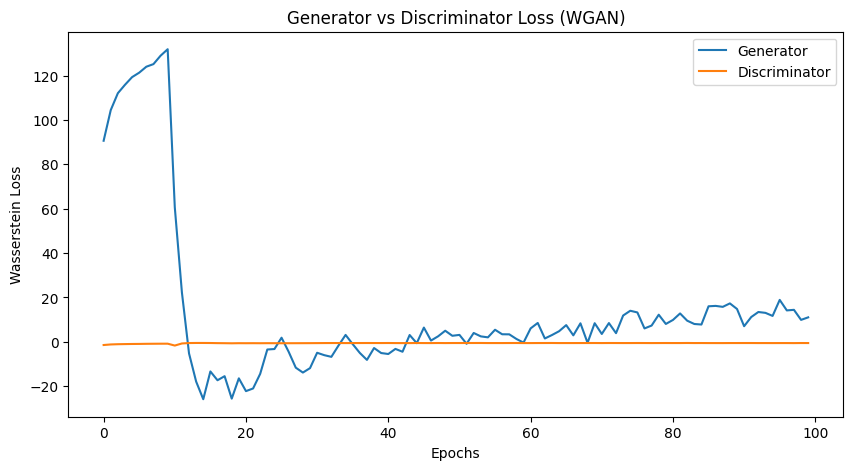

In [10]:
LEARNING_RATE = 1e-4 
BATCH_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 100
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
WEIGHT_PATH = "/scratch/s25090/wgan_GP_outputs/weights/Experiment1"
PLOT_PATH = "/scratch/s25090/wgan_GP_outputs/plots/Experiment1"
os.makedirs(WEIGHT_PATH, exist_ok=True)
os.makedirs(PLOT_PATH, exist_ok=True)
gan_model = WGANModel(z_dim=Z_DIM).to(DEVICE)
gan_model.train()

opt_gen = torch.optim.Adam(gan_model.generator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(gan_model.discriminator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
train_dataset = CIFAR()
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Starting WGAN-GP Training...")
gen_loss_list = []
dis_loss_list = []
for epoch in range(NUM_EPOCHS):
    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    batch_gen_loss = 0
    batch_dis_loss = 0
    
    for batch_idx, (real) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake = gan_model.generator(noise)
        
        critic_real = gan_model.discriminator(real).reshape(-1)
        critic_fake = gan_model.discriminator(fake).reshape(-1)
        
        loss_critic_wasserstein = -(torch.mean(critic_real) - torch.mean(critic_fake))
        
        gp = compute_gradient_penalty(gan_model.discriminator, real, fake, DEVICE)
        
        loss_critic = loss_critic_wasserstein + (LAMBDA_GP * gp)
        
        opt_critic.zero_grad()
        loss_critic.backward(retain_graph=True)
        opt_critic.step()
        batch_dis_loss += loss_critic.item()
        batch_gen_loss += -torch.mean(critic_fake).item()
        if batch_idx % CRITIC_ITERATIONS == 0:
            gen_fake = gan_model.discriminator(fake).reshape(-1)
            loss_gen = -torch.mean(gen_fake)
            
            opt_gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()
            
            loop.set_postfix(
                loss_critic=loss_critic.item(),
                loss_gen=loss_gen.item(),
                gp=gp.item()
            )

    avg_gen_loss = batch_gen_loss / (len(loader) / CRITIC_ITERATIONS)
    avg_dis_loss = batch_dis_loss / len(loader)
    
    gen_loss_list.append(avg_gen_loss)
    dis_loss_list.append(avg_dis_loss)

    print(f"Generator Loss: {avg_gen_loss:.4f}\nDiscriminator Loss: {avg_dis_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        torch.save(gan_model.state_dict(), f"{WEIGHT_PATH}/gan_epoch_{epoch+1}.pth")
        gan_model.eval()
        with torch.no_grad():
            test_z = torch.randn(8, 100).to(DEVICE)
            gan_image = gan_model.generator(test_z)
            
            comparison = torch.cat([real[:8], gan_image[:8]], dim=0)
            grid = make_grid(comparison.cpu(), nrow=8, padding=2, normalize=True)
            
            plt.figure(figsize=(12, 4))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.title(f'Top: Original | Bottom: Generated Image (Epoch {epoch+1})')
            plt.savefig(f"{PLOT_PATH}/Epoch-{epoch+1}.png")
            plt.close()

plt.figure(figsize=(10, 5))
plt.title("Generator vs Discriminator Loss (WGAN)")
plt.plot(gen_loss_list, label="Generator")
plt.plot(dis_loss_list, label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Wasserstein Loss")
plt.savefig(f"{PLOT_PATH}/Experiment1_loss.png")
plt.legend()
plt.show()